In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import stats

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
def calculate_bias(CESM_data, AWS_data, season = None):
    i = 0
    bias = list()
    for s in stations:
            #get temperature values for AWS stations
        lat_temp = lats[i]
        lon_temp = lons[i]
        
        AWS_avg = AWS_data.sel(station = s)
        CESM_avg = CESM_data.sel(lat = lat_temp, lon = lon_temp, method = 'nearest')
        
        bias.append(CESM_avg - AWS_avg)

        i = i+1
        
    return bias

In [3]:
# ### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))
cesm_masks = convert_lon(cesm_masks)
cesm_ism = cesm_masks.full_ism.values #full ice sheet
cesm_ism[cesm_ism==0] = np.nan
cesm_ism[cesm_ism>0]=1
cesm_area = cesm_masks.area.values

# # ### ----- Read CESM2 data ----- ###
cesm2_temp = xr.open_dataset('/glade/work/devond/CESM/temperature/CESM2_tas_hist.nc')['tas']
cesm2_temp = cesm2_temp.sel(lat = slice(-90,-60), time=slice("1979-01-01", "2015-01-01"))-273.15 #convert to C
cesm2_temp = convert_lon(cesm2_temp)

# ### ----- Read CESM1 data ----- ###
cesm1_temp = xr.open_dataset('/glade/work/devond/CESM/temperature/CESM1lens_TREFHT_hist2.nc')['TREFHT']
cesm1_temp = cesm1_temp.sel(lat = slice(-90,-60), time=slice("1979-01-01", "2015-01-01")) - 273.15
cesm1_temp = convert_lon(cesm1_temp)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [4]:
cesm2_year_mean = cesm2_temp.groupby(cesm2_temp.time.dt.year).mean()
cesm1_year_mean = cesm1_temp.groupby(cesm1_temp.time.dt.year).mean()

In [5]:
cesm2_map = cesm2_year_mean.mean(dim = 'year')
cesm1_map = cesm1_year_mean.mean(dim = 'year')

cesm_bias_map = cesm2_map.mean(dim = 'ensemble') - cesm1_map.mean(dim = 'ensemble')

In [6]:
cesm2_ts = (cesm2_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)
cesm1_ts = (cesm1_year_mean*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_ism*cesm_area)

cesm2_ts_mean = cesm2_ts.mean()
cesm2_ts_std = cesm2_ts.std(dim = 'year').mean()
cesm1_ts_mean = cesm1_ts.mean()
cesm1_ts_std = cesm1_ts.std(dim = 'year').mean()

cesm_bias = (cesm2_ts_mean - cesm1_ts_mean).values
uncertainty = np.sqrt((cesm2_ts_std**2 + cesm1_ts_std**2)).values

print(f'CESM2 is {cesm_bias:0.2f} +/- {uncertainty:0.2f} ◦C warmer than CESM1')

CESM2 is 2.86 +/- 0.66 ◦C warmer than CESM1


In [7]:
AWS_data = xr.load_dataset("/glade/work/devond/AWS/temp_data.nc")
AWS_data = AWS_data.rename_dims({'time':'month'})
stations = AWS_data.station.values
lats = AWS_data.lat.values
lons = AWS_data.lon.values
elevations = AWS_data.elevation.values
AWS_temp = AWS_data['TREFHT']

# Temperature and bias plots

In [8]:
cesm2_temp_month = (cesm2_temp).groupby(cesm2_temp.time.dt.month).mean() #group by season
cesm2_temp_month['month'] = AWS_temp.sel(station = 'A028').time.values

cesm1_temp_month = (cesm1_temp).groupby(cesm1_temp.time.dt.month).mean() #group by season
cesm1_temp_month['month'] = AWS_temp.sel(station = 'A028').time.values

In [9]:
AWS_bias = calculate_bias(cesm2_temp_month.mean(dim = 'ensemble'), AWS_temp)
AWS_annual_bias = list()
for item in AWS_bias:
    AWS_annual_bias.append(item.mean(dim = 'month'))

In [10]:
cesm1_month_avg= (cesm1_temp_month*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm2_month_avg= (cesm2_temp_month*cesm_ism*cesm_area).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm_seasonal_bias = cesm2_month_avg.mean(dim = 'ensemble') - cesm1_month_avg.mean(dim = 'ensemble')

In [11]:
AWS_bias_cesm1 = calculate_bias(cesm1_temp_month.mean(dim = 'ensemble'), AWS_temp)

cesm1_monthly_bias = np.zeros(12)
cesm2_monthly_bias = np.zeros(12)
for i in range(len(AWS_bias)):
    cesm1_monthly_bias = AWS_bias_cesm1[i].values + cesm1_monthly_bias
    cesm2_monthly_bias = AWS_bias[i].values + cesm2_monthly_bias

cesm2_monthly_bias = cesm2_monthly_bias/len(AWS_bias)
cesm1_monthly_bias = cesm1_monthly_bias/len(AWS_bias)

print(f'The average bias of CESM2 is {np.mean(cesm2_monthly_bias):0.2f} ◦C')
print(f'The average bias of CESM1 is {np.mean(cesm1_monthly_bias):0.2f} ◦C')

The average bias of CESM2 is -2.98 ◦C
The average bias of CESM1 is -5.18 ◦C


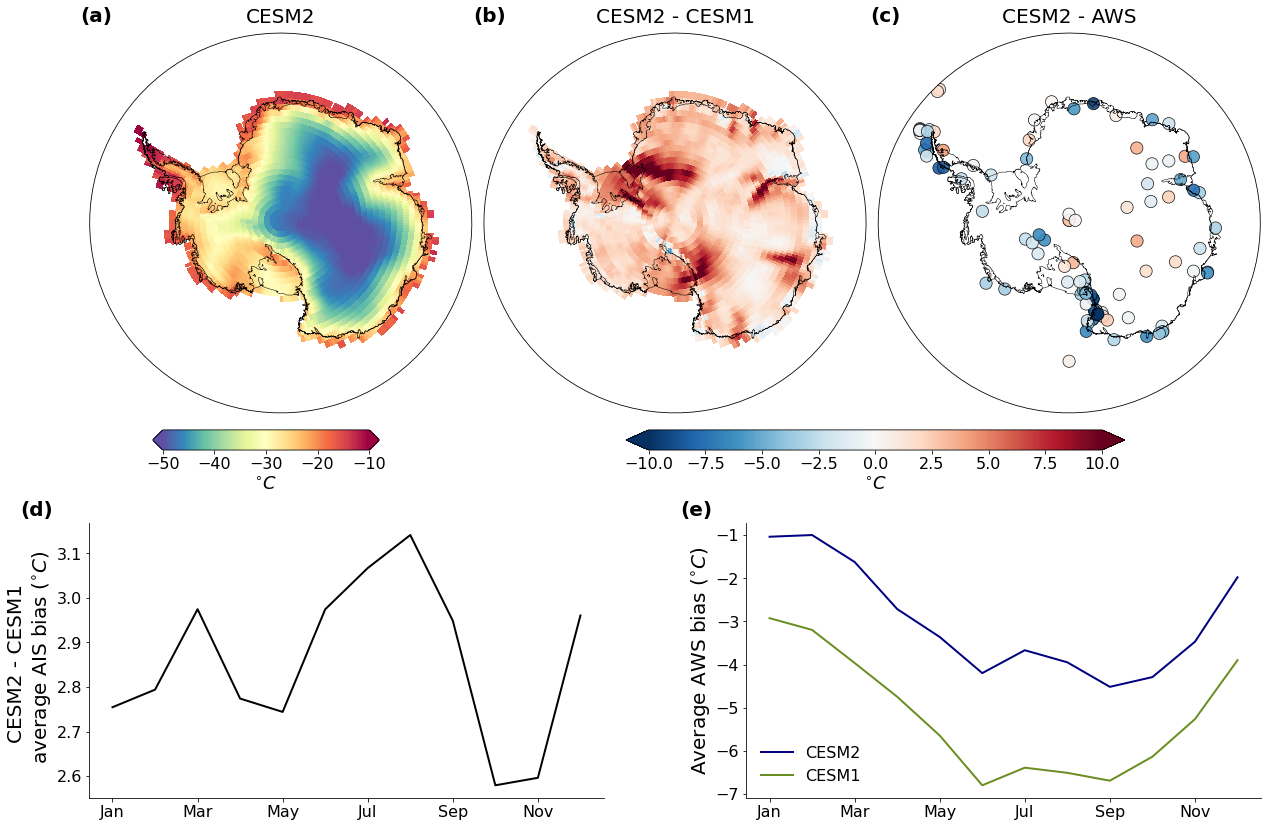

In [13]:
lon = cesm2_map.lon
lat = cesm2_map.lat

fig = plt.figure(figsize = (21, 14))
gs=GridSpec(8,18)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0:4,0:6],projection=crs_sp)
plot_antarctica(ax1,-60)
im1 = ax1.pcolormesh(lon, lat, cesm2_map.mean(dim = 'ensemble')*cesm_ism, transform = crs_ll, cmap = 'Spectral_r',vmin = -50, vmax = -10)
ax1.set_title('CESM2', fontsize = 20)
ax1.text(0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[0:4,6:12],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon, lat, cesm_bias_map*cesm_ism, transform = crs_ll,  cmap = 'RdBu_r', vmin = -10, vmax = 10)
ax2.set_title(f'CESM2 - CESM1', fontsize = 20)
ax2.text(0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[0:4,12:18],projection=crs_sp)
plot_antarctica(ax3,-60)
im3 = ax3.scatter(lons, lats, c = AWS_annual_bias, transform = crs_ll, cmap = 'RdBu_r', vmin = -10, vmax = 10, s = 150, alpha = 0.9, edgecolor = 'black',linewidth=0.7)
ax3.set_title('CESM2 - AWS', fontsize = 20)
ax3.text(0.05, 1.08, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[5:8,0:8])
ax4.plot(cesm_seasonal_bias, color = 'black', linewidth = 2)
ax4.set_xticks([0,2,4,6,8,10])
ax4.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.tick_params(labelsize=16)
ax4.set_ylabel('CESM2 - CESM1 \n average AIS bias ($^{\circ} C$)', fontsize=20)
ax4.text(-0.07, 1.08, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax5 = plt.subplot(gs[5:8,10:18])
ax5.plot(cesm2_monthly_bias, color = 'navy', linewidth = 2, label = 'CESM2')
ax5.plot(cesm1_monthly_bias, color = 'olivedrab', linewidth = 2, label = 'CESM1')
ax5.set_xticks([0,2,4,6,8,10])
ax5.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax5.spines["right"].set_visible(False)
ax5.spines["top"].set_visible(False)
ax5.tick_params(labelsize=16)
ax5.set_ylabel('Average AWS bias ($^{\circ} C$)', fontsize=20)
ax5.legend(frameon = False, prop={'size':16})
ax5.text(-0.065, 1.08, '(e)', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')


    #fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.48, 0.47, 0.33, 0.02])
cb = fig.colorbar(im2, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label='$^{\circ}C$', size=18)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.167, 0.47, 0.15, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label='$^{\circ}C$', size=18)
cb.ax.tick_params(labelsize=16)

plt.savefig('temperature.png', dpi = 300, bbox_inches = 'tight', transparent = 'True')

## Bias by season

In [43]:
AWS_bias_djf, AWS_bias_mam, AWS_bias_son, AWS_bias_jja = list(), list(), list(), list()
for item in AWS_bias:
    AWS_bias_djf.append(item.sel(month=item['month.season']=='DJF').mean(dim = 'month')) 
    AWS_bias_mam.append(item.sel(month=item['month.season']=='MAM').mean(dim = 'month')) 
    AWS_bias_jja.append(item.sel(month=item['month.season']=='JJA').mean(dim = 'month')) 
    AWS_bias_son.append(item.sel(month=item['month.season']=='SON').mean(dim = 'month')) 

cesm_bias_djf = cesm2_temp_month.sel(month=cesm2_temp_month['month.season']=='DJF').mean(dim = 'month') - cesm1_temp_month.sel(month=cesm1_temp_month['month.season']=='DJF').mean(dim = 'month')
cesm_bias_djf, lon2 = add_cyclic_point(cesm_bias_djf, coord=lon)
cesm_bias_mam = cesm2_temp_month.sel(month=cesm2_temp_month['month.season']=='MAM').mean(dim = 'month') - cesm1_temp_month.sel(month=cesm1_temp_month['month.season']=='MAM').mean(dim = 'month')
cesm_bias_mam, lon2 = add_cyclic_point(cesm_bias_mam, coord=lon)
cesm_bias_jja = cesm2_temp_month.sel(month=cesm2_temp_month['month.season']=='JJA').mean(dim = 'month') - cesm1_temp_month.sel(month=cesm1_temp_month['month.season']=='JJA').mean(dim = 'month')
cesm_bias_jja, lon2 = add_cyclic_point(cesm_bias_jja, coord=lon)
cesm_bias_son = cesm2_temp_month.sel(month=cesm2_temp_month['month.season']=='SON').mean(dim = 'month') - cesm1_temp_month.sel(month=cesm1_temp_month['month.season']=='SON').mean(dim = 'month')
cesm_bias_son, lon2 = add_cyclic_point(cesm_bias_son, coord=lon)

In [44]:
def plot_season_bias(lat,lon, cesm_bias, aws_bias, season, ax1, ax2):
    plot_antarctica(ax1,-60)
    im = ax1.pcolormesh(lon, lat, cesm_bias*cesm_ism2, transform = crs_ll,  cmap = 'RdBu_r', vmin = -10, vmax = 10)
    ax1.set_title(f'{season}\n avg. bias = {np.nanmean(cesm_bias*cesm_ism2):0.2f}' + '$^{\circ}$C', fontsize = 20)
    plot_antarctica(ax2,-60)
    ax2.scatter(lons, lats, c = aws_bias, transform = crs_ll, cmap = 'RdBu_r', vmin = -10, vmax = 10, s = 150, alpha = 0.9, edgecolor = 'black',linewidth=0.7)
    return im
    

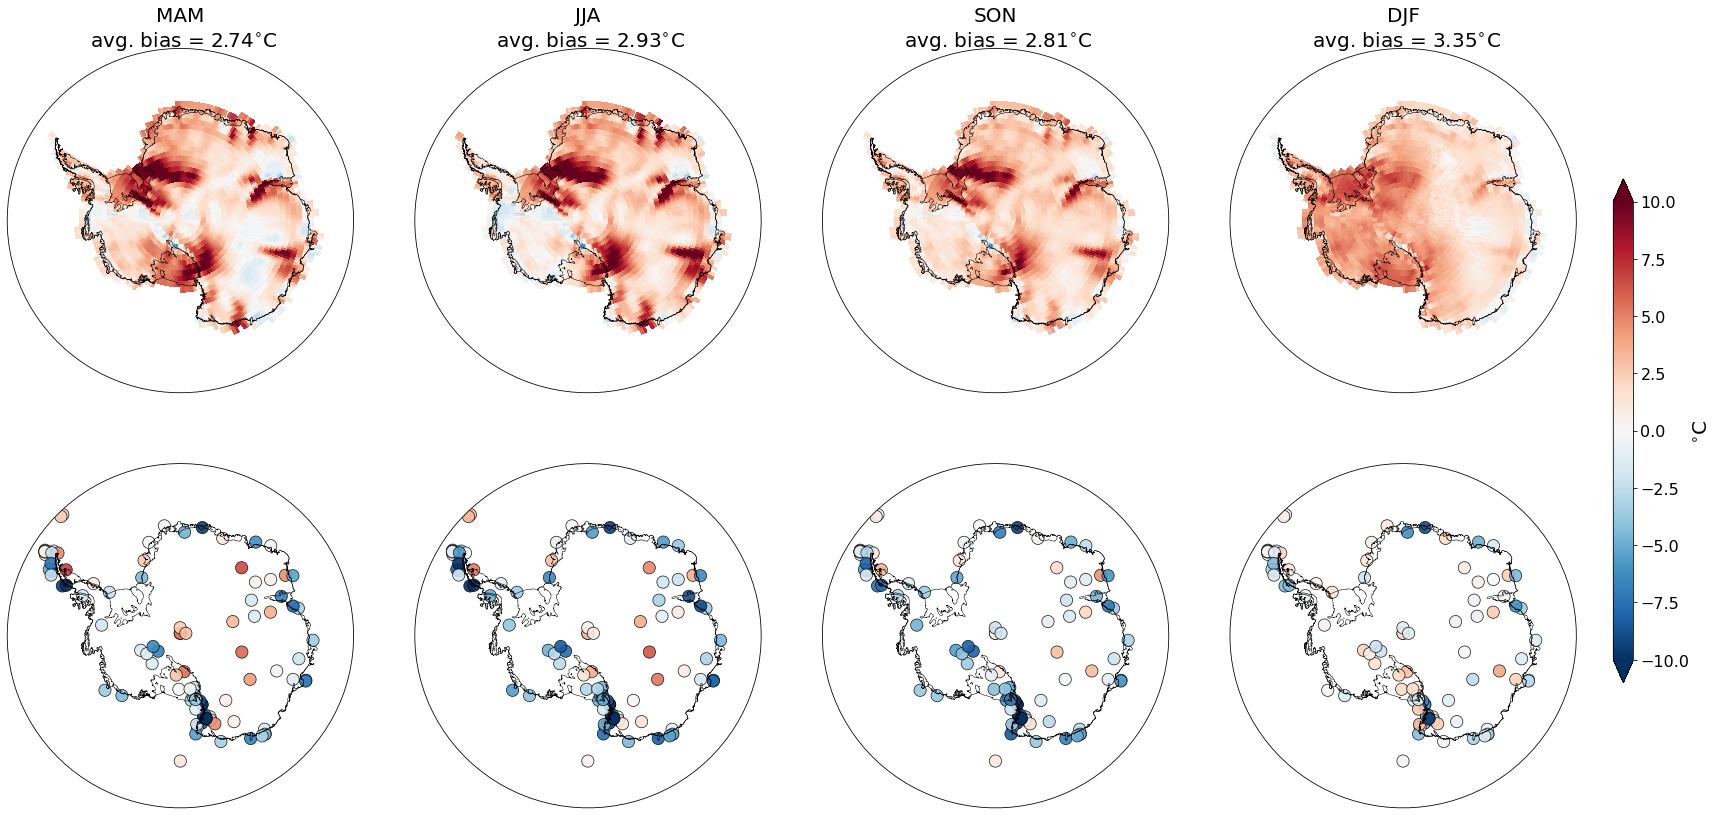

In [45]:
fig = plt.figure(figsize = (28, 14))
gs=GridSpec(2,4)

# MAM
ax1 = plt.subplot(gs[0,0],projection=crs_sp)
ax2 = plt.subplot(gs[1,0],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_mam, AWS_bias_mam, 'MAM', ax1, ax2)

# JJA
ax3 = plt.subplot(gs[0,1],projection=crs_sp)
ax4 = plt.subplot(gs[1,1],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_jja, AWS_bias_jja, 'JJA', ax3, ax4)

# SON
ax5 = plt.subplot(gs[0,2],projection=crs_sp)
ax6 = plt.subplot(gs[1,2],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_son, AWS_bias_son, 'SON', ax5, ax6)

# DJF
ax7 = plt.subplot(gs[0,3],projection=crs_sp)
ax8 = plt.subplot(gs[1,3],projection=crs_sp)
im = plot_season_bias(lat, lon2, cesm_bias_djf, AWS_bias_djf, 'DJF', ax7, ax8)


cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])
cb = fig.colorbar(im, cax=cbar_ax, orientation = 'vertical', extend = 'both')
cb.set_label(label='$^{\circ}$C', size=20)
cb.ax.tick_params(labelsize=16)

plt.savefig('seasonal_temperature_bias.png', dpi = 300)

## Temperature bias vs. elevation

In [129]:
elevations = AWS_data.elevation.values
high = list()
low = list()
for i in range(len(AWS_bias)):
    if elevations[i]>2000:
        high.append(AWS_bias[i].mean().values)
    else:
        low.append(AWS_bias[i].mean().values)

high_temp_bias = np.mean(high)
low_temp_bias = np.mean(low)


In [135]:
print(f'The average bias at high sites is {high_temp_bias:0.2f} ◦C')
print(f'The average bias at low sites is {low_temp_bias:0.2f} ◦C')

if stats.ttest_ind(high, low).pvalue < 0.05:
    print('These are statistically significantly different')
else:
    print('These are not statistically significantly different')

The average bias at high sites is 0.82 ◦C
The average bias at low sites is -3.59 ◦C
These are statistically significantly different
